In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, cross_validate,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings('ignore')

In [4]:
import shap
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [5]:
import os
os.chdir(r'C:\Users\ADMIN\Desktop\EMLforSAI')

In [8]:
df=pd.read_csv(r'ML_data.csv')
df = df.dropna(subset=['y'])
feature_columns = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B5', 
                   'C1', 'C2', 'C3', 'C4']

In [9]:
def categorize_y(value):
    if pd.isna(value):
        return np.nan
    elif value <= 3:
        return 2
    elif value == 4:
        return 1
    elif value == 5:
        return 0
    else:
        return np.nan

df['y_category'] = df['y'].apply(categorize_y)
df['y_category'] = df['y'].apply(categorize_y)
df = df.dropna(subset=['y_category'])

In [10]:
X = df[feature_columns]
y = df['y_category']

print("=== 数据概况 ===")
print(f"总样本数: {len(X)}")
print(f"特征数量: {len(feature_columns)}")
print(f"特征: {feature_columns}")
print(f"\n类别分布:")
print(y.value_counts().sort_index())
print(f"比例: {y.value_counts(normalize=True).sort_index()}")

=== 数据概况 ===
总样本数: 687
特征数量: 13
特征: ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4']

类别分布:
0    148
1    289
2    250
Name: y_category, dtype: int64
比例: 0    0.215429
1    0.420670
2    0.363901
Name: y_category, dtype: float64


In [11]:
# 读取保存的模型
model_filename = r'./ML_Classifier/xgboost_optuna_optimized.pkl'
final_model = joblib.load(model_filename)
print(f"Model loaded from: {model_filename}")

Model loaded from: xgboost_optuna_optimized.pkl


In [12]:
# 使用TreeExplainer（适用于XGBoost）
explainer = shap.TreeExplainer(final_model)
print("✅  Successful creation of SHAP TreeExplainer")

# 4. 计算SHAP值（这可能需要一些时间）
print("\nCalculating SHAP values...")
shap_values = explainer.shap_values(X)
print(f"✅ Completed SHAP value calculation")
print(f"Shape of SHAP values: {np.array(shap_values).shape}")

# 对于多分类问题，shap_values是一个列表，每个元素对应一个类别
if isinstance(shap_values, list):
    print(f"Number of Categories: {len(shap_values)}")
    for i in range(len(shap_values)):
        print(f"  SHAP value shape for category {i}: {shap_values[i].shape}")

✅  Successful creation of SHAP TreeExplainer

Calculating SHAP values...
✅ Completed SHAP value calculation
Shape of SHAP values: (3, 687, 13)
Number of Categories: 3
  SHAP value shape for category 0: (687, 13)
  SHAP value shape for category 1: (687, 13)
  SHAP value shape for category 2: (687, 13)


 1. A2  : 0.4323
 2. B2  : 0.1517
 3. B4  : 0.1358
 4. B1  : 0.1311
 5. B3  : 0.1222
 6. C4  : 0.1007
 7. C3  : 0.0844
 8. A3  : 0.0825
 9. C1  : 0.0668
10. C2  : 0.0620
11. B5  : 0.0568
12. A4  : 0.0477
13. A1  : 0.0442


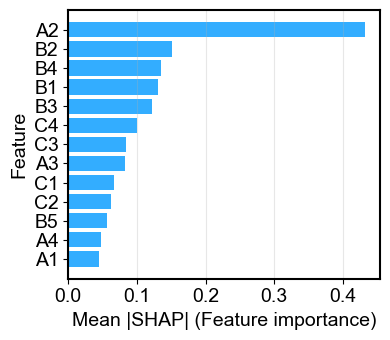

In [13]:
#计算每个特征的平均绝对SHAP值
if isinstance(shap_values, list):
    # 多分类：取所有类别的平均值
    shap_abs_mean = np.mean([np.abs(shap_values[i]).mean(axis=0) for i in range(len(shap_values))], axis=0)
else:
    # 二分类或回归
    shap_abs_mean = np.abs(shap_values).mean(axis=0)

feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'shap_importance': shap_abs_mean
}).sort_values('shap_importance', ascending=False)

for i, (feature, importance) in enumerate(zip(feature_importance_df['feature'], 
                                               feature_importance_df['shap_importance']), 1):
    print(f"{i:2d}. {feature:4s}: {importance:.4f}")

# 可视化特征重要性
# 创建图形
plt.figure(figsize=(4,3.5))
plt.rc('font',family='Arial',weight='normal')
plt.barh(feature_importance_df['feature'], feature_importance_df['shap_importance'], 
         color='#0099FF', alpha=0.8)
plt.xlabel('Mean |SHAP| (Feature importance)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
TK = plt.gca()
bwith=1.5
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)
plt.tight_layout()
# plt.savefig( r'xgboost_all_fea.png', dpi=300,transparent=True,bbox_inches = 'tight')

   feature  shap_importance
1       A2         0.608978
7       B4         0.257252
5       B2         0.136861
2       A3         0.109367
11      C3         0.107676
12      C4         0.070433
9       C1         0.056981
0       A1         0.050411
6       B3         0.045098
10      C2         0.041752


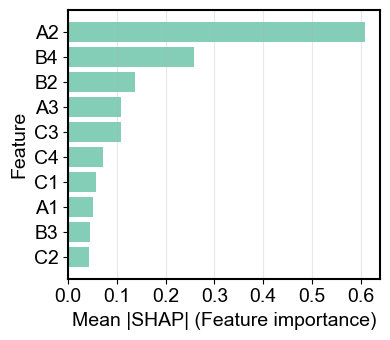

   feature  shap_importance
4       B1         0.219291
5       B2         0.199812
6       B3         0.176042
1       A2         0.146260
7       B4         0.137646
12      C4         0.104428
8       B5         0.103025
11      C3         0.088495
10      C2         0.064191
3       A4         0.058272


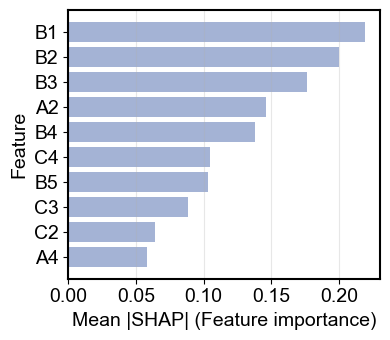

   feature  shap_importance
1       A2         0.541571
4       B1         0.161616
6       B3         0.145378
12      C4         0.127313
5       B2         0.118488
2       A3         0.095185
9       C1         0.090997
10      C2         0.080172
3       A4         0.076919
11      C3         0.056947


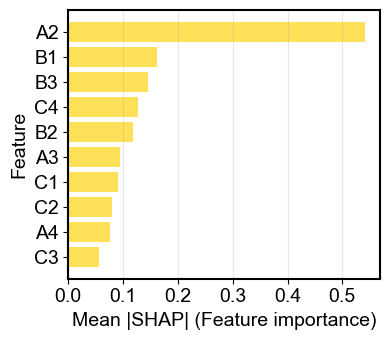

In [15]:
#计算每个特征的平均绝对SHAP值(按类别)
if isinstance(shap_values, list):
    class_names = ['Embracing','Receptive','Hesitant']
    
    for i, class_name in enumerate(class_names):
        # 计算该类别的特征重要性
        class_shap_abs = np.abs(shap_values[i]).mean(axis=0)
        class_importance_df = pd.DataFrame({
            'feature': feature_columns,
            'shap_importance': class_shap_abs
        }).sort_values('shap_importance', ascending=False)
        
        # 只显示前10个特征
        top_features = class_importance_df.head(10)
        print(top_features)
        # 创建单独的图形
        plt.figure(figsize=(4,3.5))
        plt.rc('font',family='Arial',weight='normal')
        
        # 绘制条形图
        plt.barh(range(len(top_features)), top_features['shap_importance'], 
                 color=plt.cm.Set2(i/3), alpha=0.8)
        
        # 设置y轴刻度和标签
        plt.yticks(range(len(top_features)), top_features['feature'])
        
        plt.xlabel('Mean |SHAP| (Feature importance)', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
        # 反转y轴（使重要性最高的在顶部）
        plt.gca().invert_yaxis()
        
        # 添加网格线
        plt.grid(axis='x', alpha=0.3)
        TK = plt.gca()
        bwith=1.5
        TK.spines['bottom'].set_linewidth(bwith)
        TK.spines['left'].set_linewidth(bwith)
        TK.spines['top'].set_linewidth(bwith)
        TK.spines['right'].set_linewidth(bwith)
        plt.tight_layout()
        # plt.savefig( r'xgboost_fea'+class_names[i]+'.png', dpi=300,transparent=True,bbox_inches = 'tight')
        # 调整布局并显示
        plt.tight_layout()
        plt.show()


正在绘制 Embracing 的SHAP蜂群图...

正在绘制 Receptive 的SHAP蜂群图...

正在绘制 Hesitant 的SHAP蜂群图...


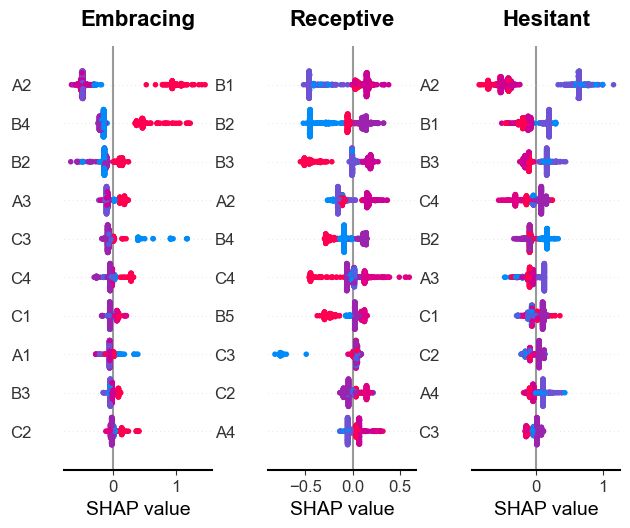

In [17]:
# 设置字体和整体样式
plt.rc('font', family='Arial', weight='normal')

# 创建包含三个子图的总图，并为颜色条预留空间
fig = plt.figure(figsize=(10, 6.8))

# 使用GridSpec创建布局，给颜色条留出位置
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.5)

cmap1 =sns.diverging_palette(250,10,as_cmap=True)
# 类别名称
class_names = ['Embracing', 'Receptive', 'Hesitant']

# 存储所有特征值数据，用于统一颜色条
all_feature_values = []

# 存储子图列表
axes = []

# 遍历三个类别，在每个子图中绘制蜂群图
for i, class_name in enumerate(class_names):
    print(f"\n正在绘制 {class_name} 的SHAP蜂群图...")
    
    # 创建子图
    ax = fig.add_subplot(gs[i])
    axes.append(ax)
    
    # 绘制当前类别的蜂群图，不显示颜色条
    shap.summary_plot(
        shap_values[i], 
        X,  # 特征数据
        feature_names=feature_columns,  # 特征名称
        max_display=10,  # 只显示最重要的8个特征，使图形更紧凑
        show=False,  # 不自动显示，让我们可以设置标题
        plot_type="dot",  # 点图（蜂群图）
        color=cmap1,
        color_bar=False  # 不在每个子图中显示颜色条

    )
    
    # 收集当前子图的特征值数据
    # SHAP summary_plot中的点颜色基于特征值
    # 我们需要获取所有特征值的范围以创建统一颜色条
    if i == 0:  # 只收集一次特征值范围
        # 假设X是DataFrame，获取所有特征的最小值和最大值
        min_val = X.min().min()
        max_val = X.max().max()
        all_feature_values.append(min_val)
        all_feature_values.append(max_val)
    
    # 设置当前子图的标题
    ax.set_title(class_name, fontsize=16, fontweight='bold', pad=15)
    
    # 设置横坐标标签和字体大小
    ax.set_xlabel('SHAP value', fontsize=14)
    
    # 设置纵坐标标签字体大小
    ax.tick_params(axis='y', labelsize=12)
    
    # 设置横坐标刻度字体大小
    ax.tick_params(axis='x', labelsize=12)
    
    # 设置边框线宽
    bwith = 1.5
    for spine in ax.spines.values():
        spine.set_linewidth(bwith)


#plt.savefig( r'Beeswarm.png', dpi=300,transparent=True,bbox_inches = 'tight')
plt.tight_layout()
plt.show()

Top 4 feature: ['A2', 'B2', 'B4']


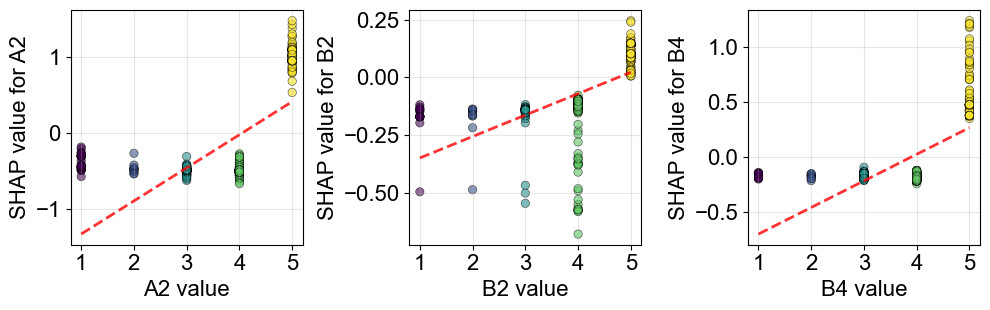

In [18]:
# 选择前3个最重要的特征进行分析
top_features = feature_importance_df.head(3)['feature'].tolist()
print(f"Top 4 feature: {top_features}")

if isinstance(shap_values, list):
    # 使用第一个类别的SHAP值进行分析
    shap_for_dependence = shap_values[0]
else:
    shap_for_dependence = shap_values

fig, axes = plt.subplots(1, 3, figsize=(10, 3.2))
plt.rc('font',family='Arial',weight='normal')
# 将axes展平为一维数组，方便迭代
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    # 获取特征在特征列中的索引
    # 注意：这里假设feature_columns是一个列表，包含所有特征名，且与X的列顺序一致
    if feature in feature_columns:
        feature_idx = feature_columns.index(feature)
    else:
        # 如果特征名不在特征列中，跳过
        print(f"特征 {feature} 不在特征列中，跳过。")
        continue
    
    # 获取该特征在所有样本中的值和对应的SHAP值
    # 注意：X是DataFrame，我们使用iloc按位置索引列
    feature_values = X.iloc[:, feature_idx].values
    shap_for_feature = shap_for_dependence[:, feature_idx]
    
    # 创建散点图
    scatter = axes[idx].scatter(feature_values, shap_for_feature, 
                               c=feature_values, cmap='viridis', 
                               alpha=0.6, edgecolors='k', linewidth=0.5)
    
    # 添加趋势线
    z = np.polyfit(feature_values, shap_for_feature, 1)
    p = np.poly1d(z)
    axes[idx].plot(np.sort(feature_values), p(np.sort(feature_values)), 
                  "r--", alpha=0.8, linewidth=2)
    
    axes[idx].set_xlabel(f'{feature} value', fontsize=16)
    axes[idx].set_ylabel(f'SHAP value for {feature}', fontsize=16)
    axes[idx].set_xticks([1,2,3,4,5])
    axes[idx].tick_params(axis='x',labelsize=16)
    axes[idx].tick_params(axis='y', labelsize=16)
    axes[idx].grid(True, alpha=0.3)

# 如果子图数量多于特征数量，隐藏多余的空子图
for idx in range(len(top_features), len(axes)):
    axes[idx].set_visible(False)
# 添加颜色条

plt.tight_layout()
# plt.savefig( r'single_force.png', dpi=300,transparent=True,bbox_inches = 'tight')
plt.show()